In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, optimize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

[Reference. empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/examples/South African Heart Disease.ipynb
](https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/South%20African%20Heart%20Disease.ipynb)

# 1. Data Preprocessing

In [ ]:
file_dir_sad = ""
df = pd.read_csv(file_dir_sad)
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [ ]:
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
target = 'chd'
X, y = df[features].values, df[target].values

# 2. Natural Cubic Splines

First, calculate knots by uniform quantiles.

Lets make 5 knots(df=4)

In [ ]:
q = np.linspace(0,1,5)
knots = []
for i in range(X.shape[1]):
    knots.append(np.unique(np.quantile(X[:,i], q)))

knots # Since 4th column('famhist') is 2-class dummy variable, # of knots be 2

[array([101., 124., 134., 148., 218.]),
 array([ 0.    ,  0.0525,  2.    ,  5.5   , 31.2   ]),
 array([ 0.98  ,  3.2825,  4.34  ,  5.79  , 15.33  ]),
 array([0., 1.]),
 array([14.7   , 22.985 , 25.805 , 28.4975, 46.58  ]),
 array([  0.    ,   0.51  ,   7.51  ,  23.8925, 147.19  ]),
 array([15., 31., 45., 55., 64.])]

In [ ]:
# the number of params in each component (i.e. degrees of freedom)
dfs = np.array([len(k)-1 for k in knots])
dfs

array([4, 4, 4, 1, 4, 4, 4])

In [ ]:
# calculate the first & last index of basis for each feature
dfs_cumsum = [0] + list(np.cumsum(dfs))
positions = [(dfs_cumsum[i-1], dfs_cumsum[i]-1) for i in range(1, len(dfs_cumsum))]
positions

[(0, 3), (4, 7), (8, 11), (12, 12), (13, 16), (17, 20), (21, 24)]

Now calculate Natural Cubic Splines basis

**Note**. For multi-dimensional case, intercept is 1 for all features i.e. there exists 6*4 + 1(dummy variable) + 1(intercept) = 26 parameters

$$ N_1(X) = 1, N_2(X) = X, N_{k+2}(X) = d_k(X) - d_{K-1}(X)$$ where

$$d_k(X) = \frac{(X-\xi_k)^3_+}{\xi_K - \xi_k} - \frac{(X - \xi_K)^3_+}{\xi_K - \xi_k} $$

To make more generl formula, define dk by:

$$dk(X,k) = \frac{(X-\xi_k)^3_+}{\xi_K - \xi_k} $$


Thus, $$d_k(X) = dk(X,k) - dk(X,K), N_{k+2}(X) = dk(X,k) - dk(X,K-1) $$

In [ ]:
def dk(X,k,k_last):
    return (X-k).clip(0) **3 / (k_last - k)

def expand_natural_cubic(X,ks):
    basis_splines = [X]
    dki_last = dk(X,ks[-2],ks[-1])
    for knot in ks[:-2]:
        dki = dk(X,knot,ks[-1])
        basis_splines.append(dki - dki_last)

    return np.hstack(basis_splines)

In [ ]:
# For each features:
for i in range(X.shape[1]):
    print(i)
    print(expand_natural_cubic(X[:,i:i+1],knots[i])[:3,:]) # 6*4 + 1 = 25 parmas

0
[[ 160.         1730.69035409  471.65471125  184.55238095]
 [ 144.          679.54700855   85.10638298   11.9047619 ]
 [ 118.           41.99145299    0.            0.        ]]
1
[[1.20000000e+01 4.46988177e+01 4.40672027e+01 2.35607777e+01]
 [1.00000000e-02 3.20512821e-08 0.00000000e+00 0.00000000e+00]
 [8.00000000e-02 1.64102564e-05 6.67690023e-07 0.00000000e+00]]
2
[[5.73000000e+00 7.46842334e+00 1.21694560e+00 2.44369336e-01]
 [4.41000000e+00 2.81209805e+00 1.18974179e-01 3.12101911e-05]
 [3.48000000e+00 1.08885017e+00 6.39446721e-04 0.00000000e+00]]
3
[[1.]
 [0.]
 [1.]]
4
[[25.3        37.35934755  0.52581504  0.        ]
 [28.87       89.24365081  8.63526534  1.38310068]
 [29.14       94.43126659  9.86777242  1.77077736]]
5
[[9.72000000e+01 3.04393124e+03 2.96759123e+03 1.97017947e+03]
 [2.06000000e+00 5.93913717e-02 2.53877488e-02 0.00000000e+00]
 [3.81000000e+00 3.75747952e-01 2.45002727e-01 0.00000000e+00]]
6
[[5.20000000e+01 1.03373469e+03 2.80636364e+02 1.80526316e+01]
 [

In [ ]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, knots=None, df=None):
        self.knots = knots
        self.df = df # (df+1)-knots calculated at uniform quantiles

    def fit(self,X,y=None):
        if self.df is not None:
            quantiles = np.linspace(0,1,self.df + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:,i], quantiles)))


        self.dfs_ = np.array([len(k)-1 for k in self.knots])
        dfs_cumsum = [0] + list(np.cumsum(self.dfs_))
        self.positions_ =  [(dfs_cumsum[i-1], dfs_cumsum[i]-1) for i in range(1, len(dfs_cumsum))]
        return self

    def transform(self,X):
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))

        return np.hstack(features_basis_splines)


    @staticmethod
    def __dk(X,k,k_last):
        return (X-k).clip(0) **3 / (k_last - k)

    @staticmethod
    def __expand_natural_cubic(X,ks):
        basis_splines = [X]
        dki_last = NaturalCubicSplineFeatures.__dk(X,ks[-2],ks[-1])
        for knot in ks[:-2]:
            dki = NaturalCubicSplineFeatures.__dk(X,knot,ks[-1])
            basis_splines.append(dki - dki_last)

        return np.hstack(basis_splines)

In [ ]:
ncs_features = NaturalCubicSplineFeatures(df=4)
add_intercept = FunctionTransformer(
    lambda X: sm.add_constant(X), validate=True)


data_pipeline = Pipeline([('scale_features', StandardScaler()),
                          ("expand_basis",ncs_features),
                          ('scale_basis',StandardScaler()),
                          ('add_intercept_column', add_intercept)])

X_exp = data_pipeline.fit_transform(X)

from numpy.linalg import matrix_rank

print("Dimension of expanded X: ",X_exp.shape)
print("Rank of expanded X: ",matrix_rank(X_exp))

Dimension of expanded X:  (462, 26)
Rank of expanded X:  26


In [ ]:
lr_naive = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False, random_state=42)

lr = lr_naive = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False, random_state=42)

expanded_lr = Pipeline([('prepare', data_pipeline),
                        ('logistic', lr)])

In [ ]:
lr_naive.fit(X,y) # No scaling and basis expandsion

LogisticRegression(C=100000000000.0, fit_intercept=False, max_iter=100000,
                   random_state=42)

In [ ]:
lr_naive.score(X,y)

0.7164502164502164

In [ ]:
expanded_lr.fit(X,y)

Pipeline(steps=[('prepare',
                 Pipeline(steps=[('scale_features', StandardScaler()),
                                 ('expand_basis',
                                  NaturalCubicSplineFeatures(df=4,
                                                             knots=[array([-1.82312277, -0.69975353, -0.21133212,  0.47245785,  3.89140771]),
                                                                    array([-0.79241702, -0.78097425, -0.35650203,  0.40634919,  6.00785675]),
                                                                    array([-1.81775279, -0.70471704, -0.19351821,  0.50741636,  5.11908241]),
                                                                    array([-0.84327...
                                                                    array([-0.69698253, -0.67612752, -0.38988221,  0.28003403,  5.32193836]),
                                                                    array([-1.90610262, -0.80969685,  0.1496582 ,  0.83491181,  1.45164006])])),
                                 ('scale_basis', StandardScaler()),
                                 ('add_intercept_column',
                                  FunctionTransformer(func=<function <lambda> at 0x7d5b06304670>,
                                                      validate=True))])),
                ('logistic',
                 LogisticRegression(C=100000000000.0, fit_intercept=False,
                                    max_iter=100000, random_state=42))])

In [ ]:
expanded_lr.score(X,y)

0.7489177489177489

## Variable Selection using AIC statistic

The AIC statistic (Section 7.5) was used to drop terms, and all the terms remaining in the final model would cause AIC to increase if deleted from the model.

In [ ]:
selected_idxs = set(range(len(features)))
for idx in selected_idxs:
    print(selected_idxs - set([idx]))

{1, 2, 3, 4, 5, 6}
{0, 2, 3, 4, 5, 6}
{0, 1, 3, 4, 5, 6}
{0, 1, 2, 4, 5, 6}
{0, 1, 2, 3, 5, 6}
{0, 1, 2, 3, 4, 6}
{0, 1, 2, 3, 4, 5}


In [ ]:
def subset_aic(selected_idxs):
    X_selected = X[:, sorted(list(selected_idxs))]
    X_selected_exp = data_pipeline.fit_transform(X_selected)
    lr = sm.Logit(y, X_selected_exp).fit_regularized(method='l1',maxiter=1000,disp=False)
    return lr.aic


current_aic = subset_aic(selected_idxs)
print("AIC for full-model: ", current_aic)

AIC for full-model:  511.34324945546047


In [ ]:
while True:
    stat = [(subset_aic(selected_idxs - set([idx])), idx) for idx in selected_idxs]
    min_aic,feature_to_remove_idx = min(stat) # Note. only compare first element

    if min_aic > current_aic:
        break

    selected_idxs -= set([feature_to_remove_idx])
    current_aic = min_aic
    print(f'REMOVE: {features[feature_to_remove_idx]}')

REMOVE: alcohol


In [ ]:
current_aic

503.5269562523516

In [ ]:
selected_idxs = sorted(list(selected_idxs))
X_selected = X[:,selected_idxs]
expanded_lr.fit(X_selected, y)

Pipeline(steps=[('prepare',
                 Pipeline(steps=[('scale_features', StandardScaler()),
                                 ('expand_basis',
                                  NaturalCubicSplineFeatures(df=4,
                                                             knots=[array([-1.82312277, -0.69975353, -0.21133212,  0.47245785,  3.89140771]),
                                                                    array([-0.79241702, -0.78097425, -0.35650203,  0.40634919,  6.00785675]),
                                                                    array([-1.81775279, -0.70471704, -0.19351821,  0.50741636,  5.11908241]),
                                                                    array([-0.84327...
                                                                    array([-2.69512851, -0.72678241, -0.05680824,  0.58287455,  4.87890572]),
                                                                    array([-1.90610262, -0.80969685,  0.1496582 ,  0.83491181,  1.45164006])])),
                                 ('scale_basis', StandardScaler()),
                                 ('add_intercept_column',
                                  FunctionTransformer(func=<function <lambda> at 0x7d5b06304670>,
                                                      validate=True))])),
                ('logistic',
                 LogisticRegression(C=100000000000.0, fit_intercept=False,
                                    max_iter=100000, random_state=42))])

$\hat{f}_j(X_j) = h_j(X_j)^T\hat{\theta}_j$ for each feature. And shaded region is cumpted by $$\hat{f}_j(X_j) \pm 2\sqrt{v_j(X_j)}$$ where $$v_j(X_j) = Var[\hat{f}_j(X_j)] = h_j(X_j)^T\Sigma_{jj}h_j(X_j) $$

$\Sigma$ is estimated by $\hat{\Sigma} = (\mathbf{X}^T\mathbf{W}\mathbf{X})^{-1}$ where $\mathbf{W}$ is the diagonal weight matrix from the logistic regression i.e. diag($p_i(1-p_i)$) $\in \mathbb{R}^{N \times N}$

In [ ]:
H = data_pipeline.fit_transform(X_selected)
predProbs = expanded_lr.predict_proba(X_selected)
W = np.diagflat(np.product(predProbs, axis=1))
cov = np.linalg.inv(H.T @ W @ H)

In [ ]:
X_min, X_max = np.min(X_selected, axis = 0), np.max(X_selected, axis = 0)
x_vals = np.vstack([np.linspace(X_min[i], X_max[i], 100)
                    for i in range(X_min.shape[0])]).T
x_vals_exp = data_pipeline.transform(x_vals)
x_vals_exp[:5,:5]

array([[ 1.        , -1.82312277, -0.61041256, -0.40654788, -0.34857527],
       [ 1.        , -1.76540024, -0.6104022 , -0.40654788, -0.34857527],
       [ 1.        , -1.70767771, -0.61032963, -0.40654788, -0.34857527],
       [ 1.        , -1.64995518, -0.61013266, -0.40654788, -0.34857527],
       [ 1.        , -1.59223265, -0.6097491 , -0.40654788, -0.34857527]])

In [ ]:
x_vals_exp = x_vals_exp[:,1:] # drop intercept
cov = cov[1:, 1:]

In [ ]:
def plot_term_natural_spline_function(ax, feature_idx, name):
    basis_start, basis_end = ncs_features.positions_[feature_idx]
    # calculate feature expansion matrix, feature cov and feature err
    feature_exp = x_vals_exp[:, basis_start:basis_end+1]
    feature_lr_coef = lr.coef_[:, basis_start+1:basis_end+2].T
    feature_cov = cov[basis_start:basis_end+1, basis_start:basis_end+1]
    feature_err = 2*np.sqrt(np.diag(feature_exp @ feature_cov @ feature_exp.T))
    feature_x_vals = x_vals[:, feature_idx]
    feature_y_vals = np.squeeze(feature_exp @ feature_lr_coef)
    # plot shaded region
    ax.fill_between(feature_x_vals,
                    feature_y_vals - feature_err,
                    feature_y_vals + feature_err,
                    color='#FFEC8B')
    # plot function line
    ax.plot(feature_x_vals, feature_y_vals, color='#00FF00', linewidth=0.8)
    # plot bottom red lines representing samples
    y_from, y_to = ax.get_ylim()
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_idx]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02],
                color='red', linewidth=0.5)
    ax.set_ylim(y_from, y_to)
    # title the plot and set ticks
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(6)
    ax.set_xlabel(f'{name}', color='#646369', fontsize=8)
    ax.set_ylabel(f'f({name})', color='#646369', fontsize=8)

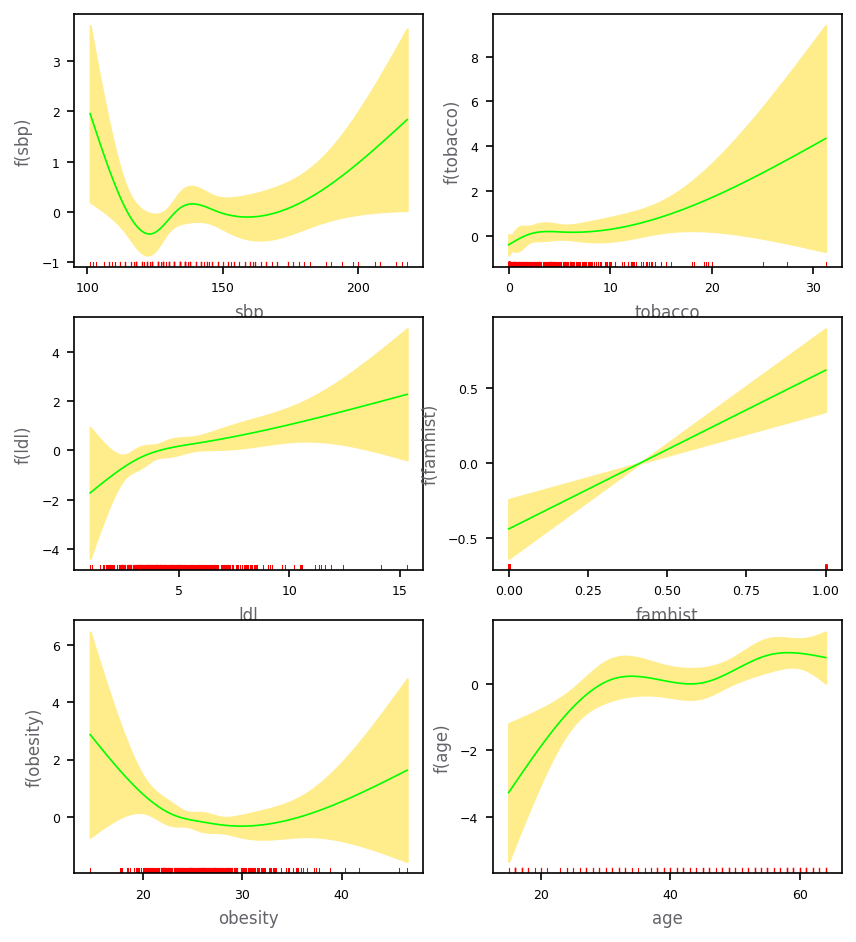

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(3.3*2, 2.3*3), dpi=150)
plt.subplots_adjust(bottom=0.05)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
plot_term_natural_spline_function(axarr[1, 1], 3, 'famhist')
plot_term_natural_spline_function(axarr[2, 0], 4, 'obesity')
plot_term_natural_spline_function(axarr[2, 1], 5, 'age')

# 3. Smooting Splines

In [ ]:
file_dir_bmd = ""
df_bmd = pd.read_csv(file_dir_bmd,sep='\t')
df_bmd.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


In [ ]:
df_male = df_bmd[df_bmd.gender == 'male']
X_male, y_male = df_male[['age']].values, df_male.spnbmd.values

In [ ]:
np.unique(X_male).shape # X is not unique!

(152,)

In [ ]:
knots = np.unique(X_male)

def expand_natural_cubic_1D(X,ks):
    basis_splines = [np.ones(shape=(X.shape[0],1)), X] ## add intercept
    dki_last = dk(X,ks[-2],ks[-1])
    for knot in ks[:-2]:
        dki = dk(X,knot,ks[-1])
        basis_splines.append(dki - dki_last)

    return np.hstack(basis_splines)

N = expand_natural_cubic_1D(X_male,knots)
N.shape

(226, 152)


$$ \begin{align*}\{\Omega_N \}_{ij} &= \int N_i^{''}(t)N_j^{''}(t)dt \\
                                   &= \int_{\xi_j}^{\xi_K} (dk^{''}(t,i) - dk^{''}(t,K-1))(dk^{''}(t,j) - dk^{''}(t,K-1))dt \\
                                   &= \int_{\xi_j}^{\xi_{K-1}}dk^{''}(t,i)dk^{''}(t,j)dt + \int_{\xi_{K-1}}^{\xi_K} (dk^{''}(t,i) - dk^{''}(t,K-1))(dk^{''}(t,j) - dk^{''}(t,K-1))dt

\end{align*} $$



Note that first & second columns and rows for $\Omega_N$ is zero vector

In [ ]:
from sympy import symbols, integrate, init_printing, simplify
init_printing()

In [ ]:
# define all our variables
x = symbols('x')
ki, kj = symbols('\\xi_i'), symbols('\\xi_j')
kl, kp = symbols('\\xi_{K}'), symbols('\\xi_{K-1}')

# define integral constructed from all our variables
dKp = (x - kp)**3/(kl - kp)
dKi = (x - ki)**3 / (kl - ki)
dKj = (x - kj)**3 / (kl - kj)
integral_part_1 = integrate(dKi.diff(x, 2)*dKj.diff(x, 2),
                            (x, kj, kp))
integral_part_2 = integrate((dKi - dKp).diff(x, 2)*(dKj - dKp).diff(x, 2),
                            (x, kp, kl))
total_integral = integral_part_1 + integral_part_2

# print the integral
simplify(total_integral)

  ⎛              2                                                            
6⋅⎝- 3⋅\xiᵢ⋅\xi_j  + 4⋅\xiᵢ⋅\xi_j⋅\xi_{K-1} + 2⋅\xiᵢ⋅\xi_j⋅\xi_{K} - \xiᵢ⋅\xi_
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                      \xiᵢ⋅\xi

     2                                   3                  2                 
{K-1}  - 2⋅\xiᵢ⋅\xi_{K-1}⋅\xi_{K} + \xi_j  - \xi_j⋅\xi_{K-1}  - 2⋅\xi_j⋅\xi_{K
──────────────────────────────────────────────────────────────────────────────
                                           2                                  
_j - \xiᵢ⋅\xi_{K} - \xi_j⋅\xi_{K} + \xi_{K}                                   

                         2        ⎞
-1}⋅\xi_{K} + 2⋅\xi_{K-1} ⋅\xi_{K}⎠
───────────────────────────────────
                                   
                                   

In [ ]:
Omega = np.zeros((len(knots), len(knots)))

def calc_integral(i, j, p, l):
        return (-18*i*j*j + 12*i*j*l + 24*i*j*p - 12*i*l*p - 6*i*p*p +
                6*j*j*j - 12*j*l*p - 6*j*p*p + 12*l*p*p) / (i*j - i*l - j*l + l*l)

for i in range(2, len(knots)):
    for j in range(2, len(knots)):
        Omega[i,j] = Omega[j,i] = calc_integral(knots[i-2],knots[j-2],knots[-2],knots[-1])


degree of freedom is $tr(\Omega_N)$. Now try to find $\lambda$ by using newton method

In [ ]:
def calc_dof_smooth(N,Omega,lambda_):
    if lambda_ < 0: # by definition, lambda is always non-negative
        lambda_ = 0
    S_l = N @ np.linalg.inv(N.T @ N + lambda_ * Omega) @ N.T
    return np.trace(S_l)

lambda_ = optimize.newton(lambda l: (calc_dof_smooth(N,Omega,l) - 12)**2, 1)
lambda_

1.0485452051737794

Calculate $\hat{\theta} = (N^TN + \lambda \Omega_N)^{-1}N^T\mathbf{y}, S_{\lambda} = N(N^TN + \lambda \Omega_N)^{-1} N^T $

In [ ]:
theta_hat = np.linalg.inv(N.T@N + lambda_ * Omega) @ N.T @ y_male
S_l = N @ np.linalg.inv(N.T @ N + lambda_ * Omega) @ N.T
fitted_values = S_l @ y_male

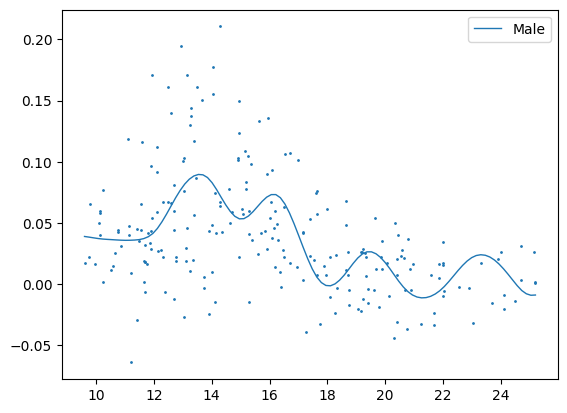

In [ ]:
x_plot_male = np.linspace(knots[0], knots[-1], 100)
x_plot_male_exp = expand_natural_cubic_1D(np.atleast_2d(x_plot_male).T,knots)
y_plot_male = x_plot_male_exp @ theta_hat


plt.plot(x_plot_male, y_plot_male, linewidth=1, label='Male')
plt.scatter(X_male, y_male, s=1)
plt.legend()
plt.show()

Compare to B-spline with degree of freedom 12

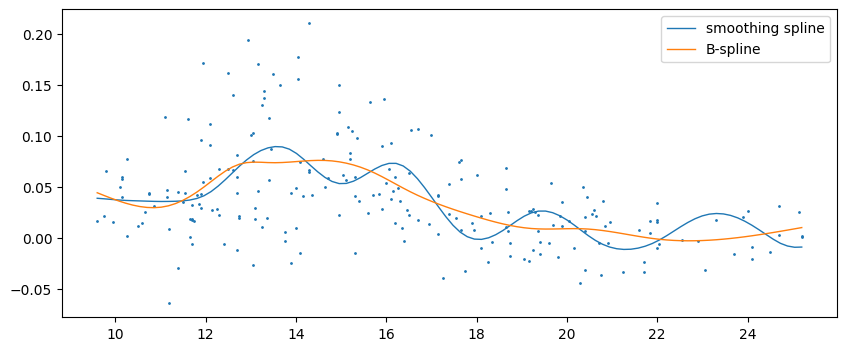

In [ ]:
q = np.linspace(0,1,13)
knots = np.unique(np.quantile(X_male, q))

X_male_exp = expand_natural_cubic_1D(X_male, knots)
B_spline_theta_hat = np.linalg.inv(X_male_exp.T @ X_male_exp) @ X_male_exp.T @ y_male

x_plot_male_exp = expand_natural_cubic_1D(np.atleast_2d(x_plot_male).T,knots)
y_plot_male_B = x_plot_male_exp @ B_spline_theta_hat

plt.figure(figsize=(10,4))
plt.plot(x_plot_male, y_plot_male, linewidth=1, label="smoothing spline")
plt.plot(x_plot_male, y_plot_male_B, linewidth=1, label="B-spline")
plt.scatter(X_male, y_male, s=1)
plt.legend()
plt.show()